In [1]:
#Plots
import pickle
import healpy as hp
import matplotlib
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})
import matplotlib.pyplot as plt
import os
os.environ['DISABLE_MPI']="true"
from os.path import join as opj
import numpy as np
from solenspipe import weighted_bin1D
from collections import OrderedDict
from pixell import curvedsky

Read in kSZ and foreground Cls 

In [2]:
#Read in ksz Cls for 10muK
cls_ksz = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_0/cmb_1999/cl_0093_rr.npy')
#And for 5muK
cls_ksz_2muK = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_2muK/cmb_1999/cl_0093_rr.npy')
cls_ksz_20muK = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_20muK/cmb_1999/cl_0093_rr.npy')
print(cls_ksz.dtype.names)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_0/cmb_1999/cl_0093_rr.npy'

In [4]:
#And some fg terms (for the lensing)
cls_fg = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/tsz_only_14.8/fg_terms_0/fg_terms_0093.npy')
print(cls_fg.dtype.names)

('cl_KphiKphi', 'trispectrum_qe', 'trispectrum_N0_qe', 'trispectrum_psh', 'trispectrum_N0_psh', 'trispectrum_lh', 'trispectrum_N0_lh', 'trispectrum_masked_qe', 'trispectrum_N0_masked_qe', 'trispectrum_masked_psh', 'trispectrum_N0_masked_psh', 'trispectrum_masked_lh', 'trispectrum_N0_masked_lh', 'trispectrum_modelsub_qe', 'trispectrum_N0_modelsub_qe', 'trispectrum_modelsub_psh', 'trispectrum_N0_modelsub_psh', 'trispectrum_modelsub_lh', 'trispectrum_N0_modelsub_lh')


Do some binning in l

In [5]:
from solenspipe import weighted_bin1D
lmin_K=10
lmax_K=300
nbin=20
def bin_cl(cl, lmin=lmin_K, lmax=lmax_K, nbin=nbin):
    ells = np.arange(len(cl))
    bin_edges = np.linspace(lmin,lmax+1,nbin).astype(int)
    nbin = len(bin_edges)-1
    cl_binned = np.zeros(nbin)
    for i,(lo,hi) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
        use = (ells>=lo)*(ells<hi)
        weights = ells[use]*(ells[use]+1)
        cl_binned[i] = np.average(cl[use], weights=ells[use]*(ells[use]+1))
    ell_mids = 0.5*(bin_edges[:-1]+bin_edges[1:])
    return ell_mids, cl_binned

In [6]:
#10muK
ell_mids, cl_ksz_raw = bin_cl(cls_ksz['kszr'])
_, cl_ksz_N0 = bin_cl(cls_ksz['kszr_N0_normed'])
cl_ksz = cl_ksz_raw-cl_ksz_N0

#2muK
_, cl_ksz_2muK_raw = bin_cl(cls_ksz_2muK['kszr'])
_, cl_ksz_2muK_N0 = bin_cl(cls_ksz_2muK['kszr_N0_normed'])
cl_ksz_2muK = cl_ksz_2muK_raw-cl_ksz_2muK_N0

#2muK
_, cl_ksz_20muK_raw = bin_cl(cls_ksz_20muK['kszr'])
_, cl_ksz_20muK_N0 = bin_cl(cls_ksz_20muK['kszr_N0_normed'])
cl_ksz_20muK = cl_ksz_2muK_raw-cl_ksz_20muK_N0

#N0s
_, total_N0 = bin_cl(cls_ksz['N0_K_normed'])
_, total_N0_lh = bin_cl(cls_ksz['N0_K_lh_normed'])
_, total_N0_psh = bin_cl(cls_ksz['N0_K_psh_normed'])
_, total_N0_2muK = bin_cl(cls_ksz_2muK['N0_K_normed'])
_, total_N0_20muK = bin_cl(cls_ksz_20muK['N0_K_normed'])

#lensing
_, cl_lens = bin_cl(cls_fg['cl_KphiKphi'])

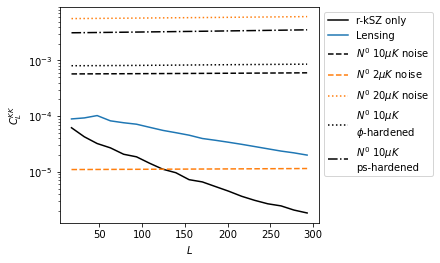

In [7]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])


#llp1 = ell_mids*(ell_mids+1)
llp1 = np.ones_like(ell_mids)
ax.plot(ell_mids, llp1*cl_ksz, 'k', label=r'r-kSZ only')
#ax.plot(ell_mids, llp1*cl_ksz_2muK, 'C1', label=r'r-kSZ only 2muK')
ax.plot(ell_mids, llp1*cl_lens, 'C0', label="Lensing")
#ax.plot(ell_mids, cl_ksz_N0, 'k--')
#ax.plot(ell_mids, cl_lens, 'C0')
ax.plot(ell_mids, llp1*total_N0, 'k--', label=r'$N^0$ 10$\mu K$ noise')
ax.plot(ell_mids, llp1*total_N0_2muK, 'C1', linestyle='--', label=r'$N^0$ 2$\mu K$ noise')
ax.plot(ell_mids, llp1*total_N0_20muK, 'C1', linestyle=':', label=r'$N^0$ 20$\mu K$ noise')
ax.plot(ell_mids, llp1*total_N0_lh, 'k', linestyle=':', label=r'$N^0$ 10$\mu K$'+'\n'+'$\phi$-hardened')
ax.plot(ell_mids, llp1*total_N0_psh, 'k', linestyle='-.', label=r'$N^0$ 10$\mu K$'+'\n'+'ps-hardened')
if np.allclose(llp1,1.):
    ax.set_ylabel(r"$C_L^{KK}$")
else:
    ax.set_ylabel(r"$C_L^{KK}$")
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
lg=ax.legend(ncol=1,bbox_to_anchor=(1., 1.), loc='upper left')
filename = "ksz_lensing_noise.png"
fig.savefig(filename,dpi=300,bbox_extra_artists=[lg],bbox_inches='tight')

## S/N estimates

Get some signal-to-noise estimates. 

$(S/N)^2 = f_{\mathrm{sky}} \sum_L (2L+1) \frac{(C_L^{KK})^2}{2(C_L^{KK} + N^0_L)^2}$

In [8]:
def get_snr(cl_KK, N0, lmax, fsky):
    Ls = np.arange(1,lmax+1)
    snr2 = fsky * np.sum(
        (2*Ls+1) * (cl_KK[1:lmax+1]**2) / 2 / (cl_KK[1:lmax+1]+N0[1:lmax+1])**2
    )
    return np.sqrt(snr2)



In [9]:
lmax=300
fsky=15./40

#10muK qe
cl_KK = cls_ksz['kszr'] - cls_ksz['kszr_N0_normed']
snr_qe_10muk = get_snr(cl_KK, cls_ksz["N0_K_normed"], 300, fsky)
snr_lh_10muK = get_snr(cl_KK, cls_ksz["N0_K_lh_normed"], 300, fsky)
snr_psh_10muK = get_snr(cl_KK, cls_ksz["N0_K_psh_normed"], 300, fsky)
snr_qe_20muk = get_snr(cl_KK, cls_ksz_20muK["N0_K_normed"], 300, fsky)
snr_lh_20muK = get_snr(cl_KK, cls_ksz_20muK["N0_K_lh_normed"], 300, fsky)
snr_psh_20muK = get_snr(cl_KK, cls_ksz_20muK["N0_K_psh_normed"], 300, fsky)
snr_qe_2muk = get_snr(cl_KK, cls_ksz_2muK["N0_K_normed"], 300, fsky)
snr_lh_2muK = get_snr(cl_KK, cls_ksz_2muK["N0_K_lh_normed"], 300, fsky)
snr_psh_2muK = get_snr(cl_KK, cls_ksz_2muK["N0_K_psh_normed"], 300, fsky)
print(snr_psh_20muK)

table_lines = ["|             | 2$\mu$K | 10$\mu$K | 20$\mu$K |",
               "| ----------- | ----------- | ----------- | ----------- |",
              " |  Optimal QE  | %.2f | %.2f | %.2f |"%(snr_qe_2muk,snr_qe_10muk,snr_qe_20muk),
              " |  Lensing-hardened  | %.2f | %.2f | %.2f |"%(snr_lh_2muK,snr_lh_10muK,snr_lh_20muK),
              " |  Point source-hardened  | %.2f | %.2f | %.2f |"%(snr_psh_2muK,snr_psh_10muK,snr_psh_20muK),]
table_str = "\n".join(table_lines)
print(table_str)

0.05609121545992456
|             | 2$\mu$K | 10$\mu$K | 20$\mu$K |
| ----------- | ----------- | ----------- | ----------- |
 |  Optimal QE  | 47.55 | 2.54 | 0.28 |
 |  Lensing-hardened  | 43.38 | 1.84 | 0.18 |
 |  point source-hardened  | 10.45 | 0.49 | 0.06 |


Make a table

|             | 2$\mu$K | 10$\mu$K | 20$\mu$K |
| ----------- | ----------- | ----------- | ----------- |
 |  Optimal QE  | 47.55 | 2.54 | 0.28 |
 |  Lensing-hardened  | 43.38 | 1.84 | 0.18 |
 |  point source-hardened  | 10.45 | 0.49 | 0.06 |




Now plot lensing-hardening in action

Need to read in sky reconstructions and average over

In [10]:
seed_start = 1980
seed_end = 2000
cl_sky_arr = []
cl_sky_lh_arr = []
for seed in range(seed_start, seed_end):
    f = '/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/recon_0/cmb_%s/cl_0093_rr.npy'%(seed)
    cl_stuff = np.load(f)
    cl_sky_arr.append(cl_stuff['sky'])
    cl_sky_lh_arr.append(cl_stuff['sky_lh'])
cl_sky_arr = np.array(cl_sky_arr)
cl_sky_lh_arr = np.array(cl_sky_lh_arr)
print(cl_sky_arr.shape)
cl_sky = cl_sky_arr.mean(axis=0)
cl_sky_lh = cl_sky_lh_arr.mean(axis=0)
    
    

(20, 6001)


In [11]:
rdn0_stuff = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/bias_0/cmb_1999/rdn0_0093_sky_000-100.npz')
rdn0_stuff_lh = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/bias_0/cmb_1999/rdn0_0093_sky_lh_000-100.npz')
n1_stuff = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/no_fgs/bias_0/cmb_1999/n1_000-400.npz.npy')
print(n1_stuff.shape)


(400, 6001)


In [12]:
rdn0 = rdn0_stuff['mcn0'].mean(axis=0)
rdn0_lh = rdn0_stuff_lh['mcn0'].mean(axis=0)
ell_mids, rdn0_binned = bin_cl(rdn0)
ell_mids, rdn0_lh_binned = bin_cl(rdn0_lh)
print(cls_ksz['kszr'])
cl_sky_binned = bin_cl(cl_sky)[1] - rdn0_binned
cl_sky_lh_binned = bin_cl(cl_sky_lh)[1]-rdn0_lh_binned
n1 = bin_cl(n1_stuff.mean(axis=0))[1]

[           nan 2.01430824e-05 4.30077592e-04 ... 5.94179383e-06
 5.94332718e-06 5.83381475e-06]


/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


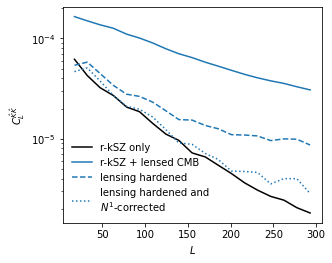

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])

ax.plot(ell_mids, cl_ksz, 'k-', label='r-kSZ only')
ax.plot(ell_mids, cl_sky_binned, 'C0', label='r-kSZ + lensed CMB')
ax.plot(ell_mids, cl_sky_lh_binned,  '--', color='C0',
        label='lensing hardened')
ax.plot(ell_mids, cl_sky_lh_binned-n1, ':', color='C0',
        label='lensing hardened and'+'\n'+r'$N^1$-corrected')

ax.set_ylabel(r"$C_L^{\hat{K}\hat{K}}$")
ax.set_xlabel(r"$L$")
ax.set_yscale('log')
#lg=ax.legend(ncol=1,bbox_to_anchor=(1., 1.), loc='upper left')
ax.legend(frameon=False)
fig.tight_layout()
filename = "lensing_hardening.png"
fig.savefig(filename,dpi=300,bbox_extra_artists=[lg],bbox_inches='tight')

Now plots some foregrounds 

Start with CIB

In [85]:
freq='0145'

In [86]:
cib7_fgterms = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/cib_only_fcut7/fg_terms_0/fg_terms_%s.npy'%freq)
cib2_fgterms = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/cib_only_fcut2/fg_terms_0/fg_terms_%s.npy'%freq)
tsz_fgterms = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/tsz_only_14.8/fg_terms_0/fg_terms_%s.npy'%freq)
print(cib7_fgterms.dtype.names)

('cl_KphiKphi', 'trispectrum_qe', 'trispectrum_N0_qe', 'trispectrum_psh', 'trispectrum_N0_psh', 'trispectrum_lh', 'trispectrum_N0_lh', 'trispectrum_masked_qe', 'trispectrum_N0_masked_qe', 'trispectrum_masked_psh', 'trispectrum_N0_masked_psh', 'trispectrum_masked_lh', 'trispectrum_N0_masked_lh')


In [87]:
ell_mids,cib_fcut7_cl = bin_cl(cib7_fgterms['trispectrum_masked_qe'])
ell_mids,cib_fcut7_psh_cl = bin_cl(cib7_fgterms['trispectrum_masked_psh'])
ell_mids,cib_fcut2_psh_cl = bin_cl(cib2_fgterms['trispectrum_masked_psh'])
_,cib_fcut2_cl = bin_cl(cib2_fgterms['trispectrum_masked_qe'])
_,tsz_cl = bin_cl(tsz_fgterms['trispectrum_qe'])

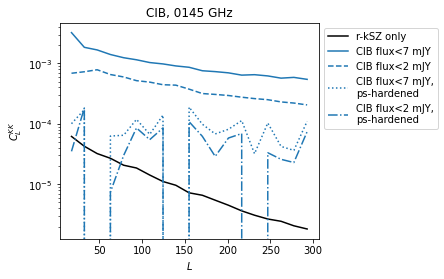

In [88]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])


#llp1 = ell_mids*(ell_mids+1)
llp1 = np.ones_like(ell_mids)
ax.plot(ell_mids, llp1*cl_ksz, 'k', label=r'r-kSZ only')

ax.plot(ell_mids, llp1*cib_fcut7_cl, 'C0', label=r'CIB flux<7 mJY')
ax.plot(ell_mids, llp1*cib_fcut2_cl, '--', color='C0', label=r'CIB flux<2 mJY')
ax.plot(ell_mids, llp1*cib_fcut7_psh_cl, ':', color='C0', 
        label=r'CIB flux<7 mJY,'+'\n'+'ps-hardened')
ax.plot(ell_mids, llp1*cib_fcut2_psh_cl, '-.', color='C0', 
        label=r'CIB flux<2 mJY,'+'\n'+'ps-hardened')

ax.set_yscale('log')
lg=ax.legend(ncol=1,bbox_to_anchor=(1., 1.), loc='upper left')

ax.set_xlabel(r'$L$')
filename = "cib_only_%s.png"%freq
ax.set_title("CIB, %s GHz"%freq)
ax.set_ylabel(r"$C_L^{KK}$")
fig.savefig(filename,dpi=300,bbox_extra_artists=[lg],bbox_inches='tight')

And now tSZ

In [89]:
tsz_fgterms_14p8 = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/tsz_only_14.8/fg_terms_0/fg_terms_%s.npy'%freq)
tsz_fgterms_14p5 = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/tsz_only_14.5/fg_terms_0/fg_terms_%s.npy'%freq)

In [90]:
ell_mids,tsz_14p8_cl = bin_cl(tsz_fgterms_14p8['trispectrum_qe'])
ell_mids,tsz_14p8_masked_cl = bin_cl(tsz_fgterms_14p8['trispectrum_masked_qe'])
ell_mids,tsz_14p5_masked_cl = bin_cl(tsz_fgterms_14p5['trispectrum_masked_qe'])


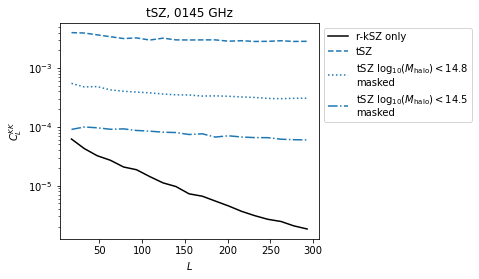

In [91]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])


#llp1 = ell_mids*(ell_mids+1)
llp1 = np.ones_like(ell_mids)
ax.plot(ell_mids, llp1*cl_ksz, 'k', label=r'r-kSZ only')

ax.plot(ell_mids, llp1*tsz_14p8_cl, '--', color='C0', label=r'tSZ')
ax.plot(ell_mids, llp1*tsz_14p8_masked_cl, ':', color='C0', 
        label=r'tSZ $\log_{10}(M_{\mathrm{halo}})<14.8$'+'\n'+'masked')
ax.plot(ell_mids, llp1*tsz_14p5_masked_cl, '-.', color='C0', 
        label=r'tSZ $\log_{10}(M_{\mathrm{halo}})<14.5$'+'\n'+'masked')

ax.set_yscale('log')
lg=ax.legend(ncol=1,bbox_to_anchor=(1., 1.), loc='upper left')
ax.set_xlabel(r'$L$')
ax.set_title("tSZ, %s GHz"%freq)
filename = "tsz_only_%s.png"%freq
ax.set_ylabel(r"$C_L^{KK}$")
fig.savefig(filename,dpi=300,bbox_extra_artists=[lg],bbox_inches='tight')

And now kSZ

In [66]:
ksz_fgterms_14p8 = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/ksz_only_14.8/fg_terms_0/fg_terms_%s.npy'%freq)
#tsz_fgterms_14p5 = np.load('/global/cscratch1/sd/maccrann/cmb/ksz/tsz_only_14.5/fg_terms_0/fg_terms_%s.npy'%freq)

In [67]:
ell_mids,ksz_14p8_cl = bin_cl(ksz_fgterms_14p8['trispectrum_qe'])
ell_mids,ksz_14p8_masked_cl = bin_cl(ksz_fgterms_14p8['trispectrum_masked_qe'])

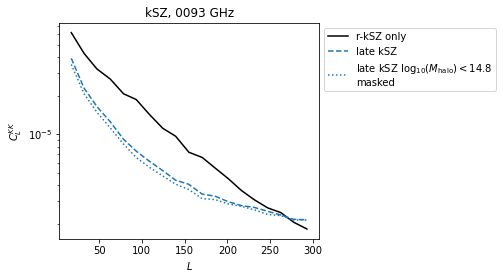

In [84]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])


#llp1 = ell_mids*(ell_mids+1)
llp1 = np.ones_like(ell_mids)
ax.plot(ell_mids, llp1*cl_ksz, 'k', label=r'r-kSZ only')

ax.plot(ell_mids, llp1*ksz_14p8_cl, '--', color='C0', label=r'late kSZ')
ax.plot(ell_mids, llp1*ksz_14p8_masked_cl, ':', color='C0', 
        label=r'late kSZ $\log_{10}(M_{\mathrm{halo}})<14.8$'+'\n'+'masked')
#ax.plot(ell_mids, llp1*tsz_14p5_masked_cl, '-.', color='C0', 
#        label=r'tSZ $\log_{10}(M_{\mathrm{halo}})<14.5$ masked')

ax.set_yscale('log')
lg=ax.legend(ncol=1,bbox_to_anchor=(1., 1.), loc='upper left')
ax.set_xlabel(r'$L$')
ax.set_title("kSZ, %s GHz"%freq)
filename = "ksz_only_%s.png"%freq
ax.set_ylabel(r"$C_L^{KK}$")
fig.savefig(filename,dpi=300,
            bbox_extra_artists=[lg],bbox_inches='tight')

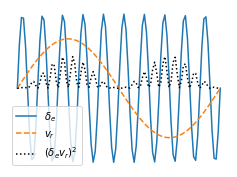

In [149]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(4,3))

x = np.linspace(0, 20*np.pi, 100)
delta_e = np.sin(x)
vr = np.sin(x/10)/1.5

ax.plot(x, delta_e, color='C0', label=r'$\delta_e$')
ax.plot(x, vr, color='C1', linestyle='--', label=r'$v_r$')
ax.plot(x, (vr*delta_e)**2, 'k:', label=r'$(\delta_e v_r)^2$')
ax.legend()
#ax.set_xlabel("Position on sky")
ax.axis('off')
fig.savefig('ksz_diagram.png',dpi=300)